In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Import CSV Files

<h3>Checking and Cleaning data</h3>

In [2]:
#Checking the data
Cus_df =pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Customer Acqusition.csv")
Repay_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/Repayment.csv")
Spend_df=pd.read_csv("/kaggle/input/credit-card-exploratory-data-analysis/spend.csv")

Cus_cy_df=Cus_df.copy()
Repay_cy_df=Repay_df.copy()
Spend_cy_df=Spend_df.copy()

#Spend_df.sample(5)

In [3]:
# Checking for missing data

"""
No Missing Data 
Cus_df.isnull().sum()
Spend_df.isnull().sum()
Repay_df.isnull().sum() - missing data
"""

#Cus_df.describe(include='all')
#Spend_df.describe(include='all')
#Repay_df.describe(include='all')


'\nNo Missing Data \nCus_df.isnull().sum()\nSpend_df.isnull().sum()\nRepay_df.isnull().sum() - missing data\n'

In [4]:
#check num col and row in Repay_df
Repay_df.shape

#Drop Unnamed:4 column - it is uncessary columns
#Fill NAN with its index+1 in the columns SL No: - we might need it later on
Repay_cy_df = Repay_cy_df.drop(labels='Unnamed: 4', axis=1)
Repay_cy_df['SL No:'] = Repay_cy_df.index+1
Repay_cy_df = Repay_cy_df.dropna()
Repay_cy_df = Repay_cy_df.rename(columns={"Month":"Repay Date","Amount":"Repay Amt"})
Repay_cy_df['Repay Date']=pd.to_datetime(Repay_cy_df['Repay Date'], format='%d-%b-%y', errors='ignore')


#Corret Spelling
Cus_cy_df = Cus_df.rename(columns={"Product":"Tier"})
Cus_cy_df['Tier'] = Cus_cy_df['Tier'].replace('Platimum', 'Platinum')


Spend_cy_df['Type']= Spend_cy_df['Type'].replace('PETRO','PETROL')
Spend_cy_df = Spend_cy_df.rename(columns={"Month":"Purchase Date","Amount":"Spend Amt"})
Spend_cy_df['Purchase Date']=pd.to_datetime(Spend_cy_df['Purchase Date'], format='%d-%b-%y', errors='ignore')


#Clean_Repay_df.shape
#Cus_df['Customer'].shape
#Cus_cy_df

In [5]:
#Additional Categories 

def agegroup (age):
#     if age < 13:
#         return 'kid'
    if age < 20:
        return 'Teenager'
    elif age >=20 and age <65:
        return 'Adult'
    elif age >= 65:
        return 'OlderAdult'
Cus_cy_df['AgeGroup'] = Cus_cy_df['Age'].apply(agegroup)


In [6]:
Cus_cy_df.loc[Cus_cy_df['Age'] < 20]

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup
13,14,A14,16,BANGALORE,Gold,500000.0,C14,Salaried_Pvt,Teenager
32,33,A33,19,BOMBAY,Platinum,10002.0,C15,Salaried_MNC,Teenager
40,41,A41,13,COCHIN,Platinum,500000.0,C23,Govt,Teenager
62,63,A63,15,BANGALORE,Gold,500000.0,C25,Self Employed,Teenager
67,68,A68,12,TRIVANDRUM,Silver,100000.0,C30,Self Employed,Teenager
69,70,A70,16,BOMBAY,Platinum,10001.0,C32,Self Employed,Teenager
89,90,A90,16,COCHIN,Gold,500000.0,C13,Govt,Teenager


# Thing to look into

1. Who is our cilent?
2. What is their spending habit? monthly/quarterly/yearly?
3. Identify the most popular products/services for which the credit card is used
3. How many spent within their credit card monthly?
1. What product is spend on the most on each of the city?
1. Identify factors that are most indicative of a customer being at risk of defaulting on their credit card payments.
1. Investigate if there's a correlation between spending and repayment ability across different age groups or cities.
1. **Credit Score Prediction:** Build a model to predict future credit scores based on spending and repayment habits.
2. **Churn Prediction:** Use machine learning algorithms to predict which customers are most likely to churn in the future.
1. **Credit Limit Recommendations:** Develop a model to recommend credit limit adjustments based on a customer's spending and repayment history.
2. **Targeted Marketing:** Use customer segmentation to develop targeted marketing strategies. For example, offering premium cards to high-value segments.


- What 
- So What 
- Now What

# Visualisation of the data

In [7]:
#Load Visualisation Plugin

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
# from matplotlib.colors import ListedColormap

sns.set()

In [8]:
# Cus_N_Spend_df.loc[Cus_N_Spend_df['Tier']=='Silver'].count
#Cus_cy_df.loc[Cus_cy_df['Tier']=='Silver']


<h2>Who is our cilent?</h2>

In [9]:
Cus_N_Spend_df = pd.merge(Cus_cy_df,Spend_cy_df,on='Customer',how='inner')
# Cus_N_Spend_df['Limit'].unique()

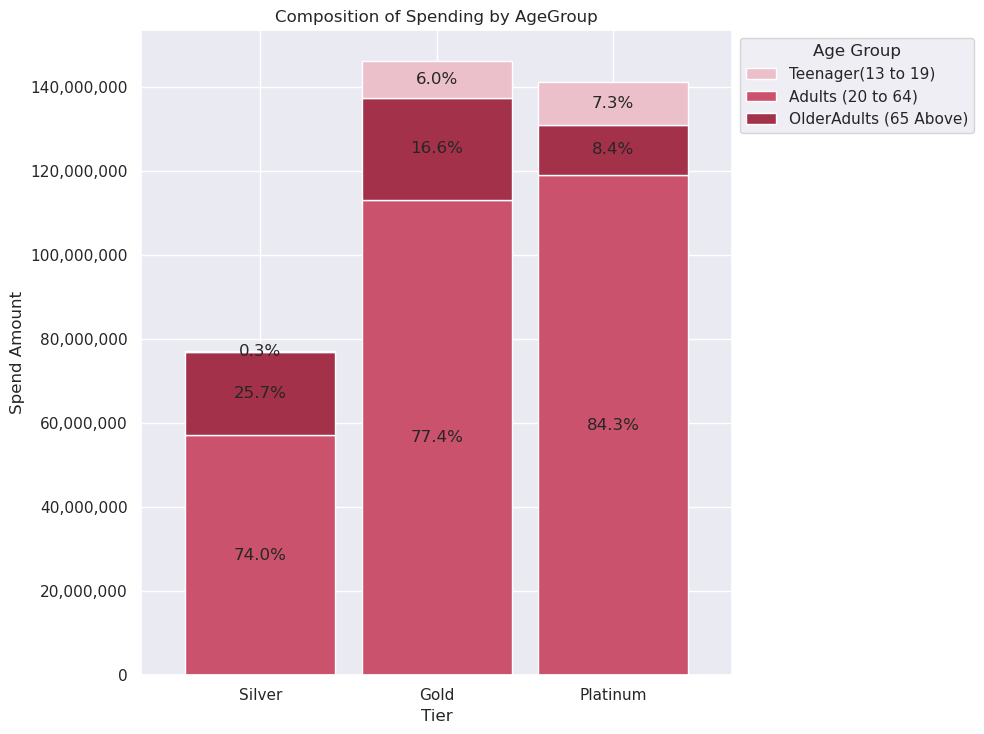

In [10]:
# Sorting the data by 'Tier' and 'AgeGroup'
amount_sum_by_agegroup_type = Cus_N_Spend_df.groupby(['AgeGroup', 'Tier'])['Spend Amt'].sum().reset_index()
amount_sum_by_agegroup_type.sort_values(['Tier', 'AgeGroup'], inplace=True)


#color_palette
stack_color_palette=['#CB526C','#A4314A','#ECC0CA']


# Create the pivot data again
pivot_data = amount_sum_by_agegroup_type.pivot(index='Tier', columns='AgeGroup', values='Spend Amt')

# Create the plot
ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar',stacked=True,figsize=(10,7.5),color=stack_color_palette, width=0.85)

# Set labels and title
plt.xlabel('Tier')
plt.ylabel('Spend Amount')
plt.title('Composition of Spending by AgeGroup')

# Set the order of x-axis ticks
preferred_order_tier = ['Silver', 'Gold', 'Platinum']
ax.set_xticklabels(preferred_order_tier)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Format y-axis ticks with thousands separator
from matplotlib import ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adult', 'OlderAdult']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))

#rename legends
labels = ['Teenager(13 to 19)', 'Adults (20 to 64)', 'OlderAdults (65 Above)']
ax.legend(handles, labels, title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))


# Annotate the bars
for idx, label in enumerate(preferred_order_tier):
    total = pivot_data.loc[label].sum()  # total amount for this tier
    y_offset = 0  # To keep track of where to put text in the y-axis
    for col in pivot_data.columns:
        value = pivot_data.loc[label, col]
        if value == 0:  # Skip zero values
            continue
        percentage = (value / total) * 100  # Calculate the percentage
        y_pos = y_offset + (value / 2)  # Position to place text in y-axis
        ax.text(idx, y_pos, f"{percentage:.1f}%", ha='center', va='center')
        y_offset += value # Increase the y_offset for next iteration

    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


<h2>Transaction, Spend Amount, Mean, Median</h2>

In [11]:
sorted_tiers = ['Silver', 'Gold', 'Platinum']

grouped_data = Cus_N_Spend_df.groupby('Tier')['Type'].value_counts()
grouped_sum = Cus_N_Spend_df.groupby('Tier')['Type'].count()
grouped_Amount_sum = Cus_N_Spend_df.groupby('Tier')['Spend Amt'].sum()
grouped_Amount_mean = Cus_N_Spend_df.groupby('Tier')['Spend Amt'].mean()
grouped_Amount_median = Cus_N_Spend_df.groupby('Tier')['Spend Amt'].median()

table = grouped_data.unstack().fillna(0)
table['Transaction'] = grouped_sum
table['Spend Amt'] =  grouped_Amount_sum.apply(lambda x: "{:,.0f}".format(x))
table['Mean Amt']=  grouped_Amount_mean.apply(lambda x: "{:,.0f}".format(x))
table['Median Amt']=  grouped_Amount_median.apply(lambda x: "{:,.0f}".format(x))

sorted_table = table.reindex(sorted_tiers)
sorted_table.index.name = None

sorted_table.rename(columns={'Type': 'Tier'}, inplace=True)
sorted_table.rename_axis(columns=None, inplace=True)
sorted_table.iloc[:,-4:]
# sorted_table.describe()


,Transaction,Spend Amt,Mean Amt,Median Amt
Silver,320,"77,128,966","241,028","233,436"
Gold,610,"146,200,355","239,673","239,598"
Platinum,570,"141,314,753","247,921","241,250"


<h2>What is their spending habit? monthly/quarterly/yearly?</h2>

In [12]:
#split_date = Cus_N_Spend_df['Date'].str.split('-', expand=True)

# df=pd.merge(Cus_N_Spend_df,Repay_cy_df,on='Customer',how='inner')
# df_grouped = df.groupby(['Customer','Tier'])['Spend Amt'].sum().apply(lambda x: "{:,.0f}".format(x))

df_merged = pd.merge(Cus_N_Spend_df, Repay_cy_df, on='Customer', how='inner')
# df_grouped

In [13]:
# Ensure your 'purchase date' and 'repay date' columns are in datetime format
df_merged['purchase date'] = pd.to_datetime(df_merged['Purchase Date'])
df_merged['repay date'] = pd.to_datetime(df_merged['Repay Date'])

# Create month-year columns for purchase and repay
df_merged['purchase_month_year'] = df_merged['Purchase Date'].dt.to_period('M')
df_merged['repay_month_year'] = df_merged['Repay Date'].dt.to_period('M')

# Define aggregation functions
agg_funcs = {
    'Spend Amt': ['sum'],
    'Repay Amt': ['sum'],
    'purchase date': ['min'],  # Latest purchase date
    'repay date': ['max'],  # Latest repayment date
    'Limit': 'max'
}

# Group by customer, tier, and month-year
df_grouped = df_merged.groupby(['Customer', 'Tier']).agg(agg_funcs).reset_index()

# Flatten the multi-level column index if needed
df_grouped.columns = [ '_'.join(col).strip() for col in df_grouped.columns.values]


#Function
def years_to_years_months(years_decimal):
    whole_years = int(years_decimal)
    remaining_months = int((years_decimal - whole_years) * 12)
    return f"{whole_years} yrs and {remaining_months} mths"


def complex_risk_group (row):
    ratio = row['Repay Amt_sum'] / row['Spend Amt_sum']
#     age = row['Num of Years']
#     limit_utilization = row['Spend Amt_sum'] / row['Limit_max']
    
#     if age < 1:
#         return 'New Account - Review'
#     else: 
    if ratio < 0.3:
        return 'High-Risk'
    elif ratio >=0.3 and ratio <1:
        return 'Medium-Risk'
    elif ratio >=1:
        return 'Low-Risk'
#     if limit_utilization > 0.8:
#         return 'High Utilization - High Risk' 
    
  


# Compute outstanding amount and other metrics as needed
df_grouped['Num of Years'] = df_grouped['purchase date_min'] - df_grouped['repay date_max']
df_grouped['Num of Years'] = abs(df_grouped['Num of Years'].dt.days / 365.25)
#.apply(years_to_years_months)

df_grouped['Outstanding_Amt'] = df_grouped['Repay Amt_sum'] - df_grouped['Spend Amt_sum']
df_grouped['Risk_Group'] = df_grouped['Repay Amt_sum']/df_grouped['Spend Amt_sum']
df_grouped['Risk_Group'] = df_grouped.apply(complex_risk_group, axis=1)



# df_grouped.loc[df_grouped['Customer_']=="A1"]
# df_grouped.loc[df_grouped['Customer_']=="A12"]
# df_grouped.loc[df_grouped['Num of Years']<=1]
# df_grouped.loc[df_grouped['Risk_Group']=="Medium-Risk"]

df_grouped.head(10)

,Customer_,Tier_,Spend Amt_sum,Repay Amt_sum,purchase date_min,repay date_max,Limit_max,Num of Years,Outstanding_Amt,Risk_Group
0,A1,Gold,9.256865e+07,8.556645e+07,2004-01-03,2006-11-21,500000.0,2.882957,-7002199.62,Medium-Risk
1,A10,Gold,6.925364e+07,6.652166e+07,2004-01-15,2006-07-11,500000.0,2.485969,-2731988.34,Medium-Risk
2,A100,Silver,2.247869e+05,6.955119e+04,2004-01-25,2004-01-25,100000.0,0.000000,-155235.69,Medium-Risk
3,A11,Gold,8.131010e+07,9.559681e+07,2004-01-12,2006-07-11,500000.0,2.494182,14286714.12,Low-Risk
4,A12,Gold,2.536746e+08,2.583776e+08,2004-01-03,2006-10-03,500000.0,2.748802,4702995.12,Low-Risk
5,A13,Gold,2.551798e+08,2.967320e+08,2004-01-03,2006-11-03,500000.0,2.833676,41552195.40,Low-Risk
6,A14,Gold,2.374937e+08,2.462413e+08,2004-01-15,2006-12-03,500000.0,2.882957,8747655.33,Low-Risk
7,A15,Gold,9.153144e+07,1.111083e+08,2004-01-12,2006-10-03,500000.0,2.724162,19576816.60,Low-Risk
8,A16,Gold,1.055441e+08,8.519656e+07,2004-01-03,2006-11-03,500000.0,2.833676,-20347579.20,Medium-Risk
9,A17,Gold,8.474283e+07,1.056875e+08,2004-01-03,2006-12-03,500000.0,2.915811,20944670.80,Low-Risk


In [14]:

# # Define aggregation functions for each column you're interested in
# agg_funcs = {
#     'Spend Amt': 'sum',
#     'Repay Amt': 'sum',
# #     'Purchase Date': 'max',
# #     'Repay Date': 'max',
#     'Limit': 'max',
#     'Segment':'first',
#     'Company': 'first',  # or 'max', 'min', 'mean', etc. depending on what you want
#     'City': 'first',     # or 'max', 'min', 'mean', etc. depending on what you want
#     'Age': 'mean'        # or 'max', 'min', 'mean', etc. depending on what you want
# }

# # Perform the groupby and aggregation
# df_grouped = df_merged.groupby(['Customer', 'Tier']).agg(agg_funcs).reset_index()

# # Format the Spend and Repay Amounts
# df_grouped['Spend Amt'] = df_grouped['Spend Amt'].apply(lambda x: "{:,.0f}".format(x))
# df_grouped['Repay Amt'] = df_grouped['Repay Amt'].apply(lambda x: "{:,.0f}".format(x))



# df_grouped.loc[df_grouped['Spend Amt'] > df_grouped['Repay Amt']].head(5)


In [15]:
# df.columns

In [16]:
# filtered_col = ["Customer","Spend Amt","Day","Month","Year"]
# Spend_Repay_df = df.head(5)

<h2> How many spent within their credit card monthly? </h2>

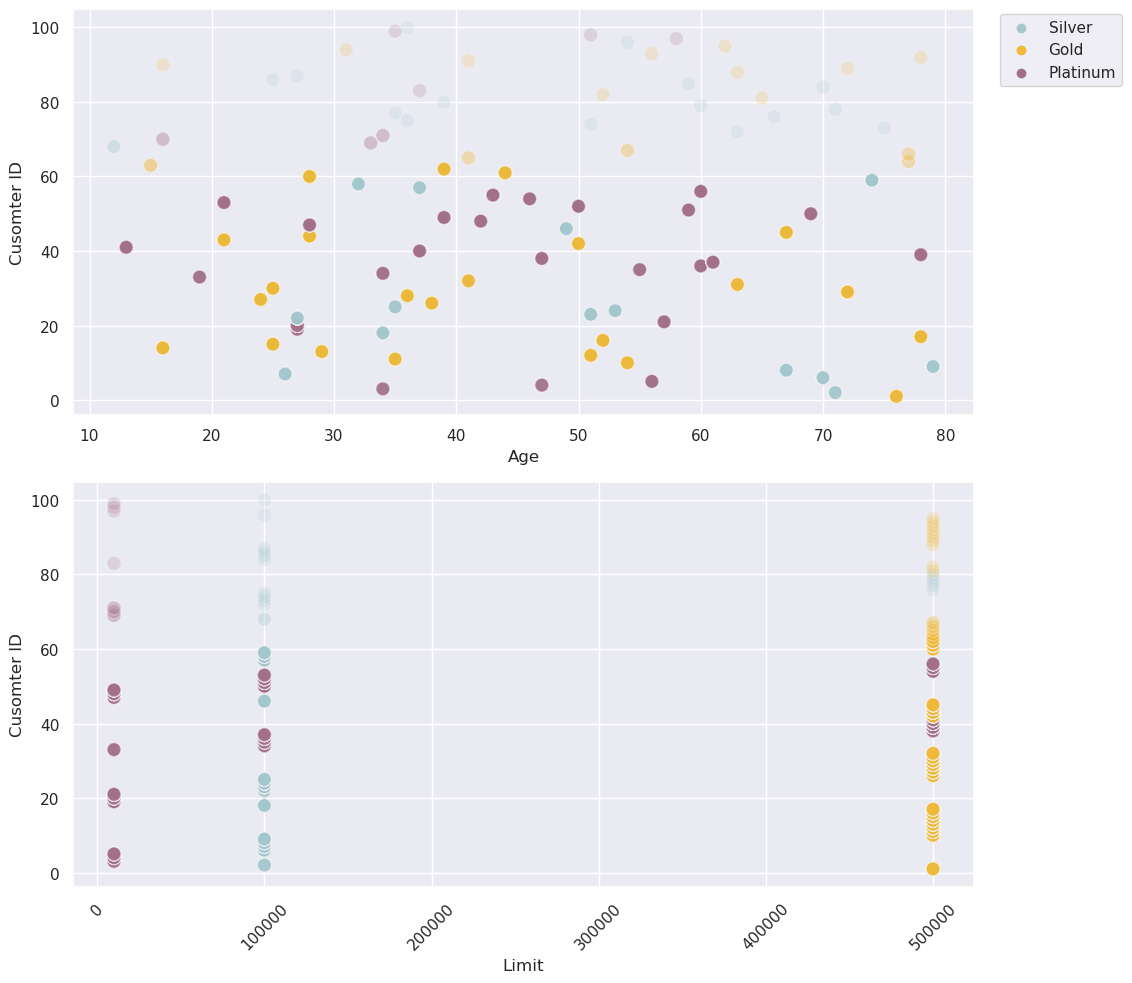

In [17]:
#can check if their monthly transation

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

#color plattee
color_palette=['#F0B93A','#A4C7CE','#A2708A']

# Create the first scatter plot on the first subplot
sns.scatterplot(x='Age', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2,palette=color_palette,ax=axes[0])

sns.scatterplot(x='Limit', y='No', hue='Tier', data=Cus_N_Spend_df,s=100,alpha=0.2,palette=color_palette,ax=axes[1])

# Remove the legend from the first subplot
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add the legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()

preferred_order = ['Silver', 'Gold', 'Platinum']
sorted_handles, sorted_labels = zip(*sorted(zip(handles, labels), key=lambda x: preferred_order.index(x[1])))

fig.legend(sorted_handles,sorted_labels, loc='upper left', bbox_to_anchor=(1, 0.985))

ylabel = "Cusomter ID"
axes[0].set_ylabel(ylabel = ylabel)
axes[1].set_ylabel(ylabel = ylabel)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

<h2>Identify the most popular products/services for which the credit card is used</h2>

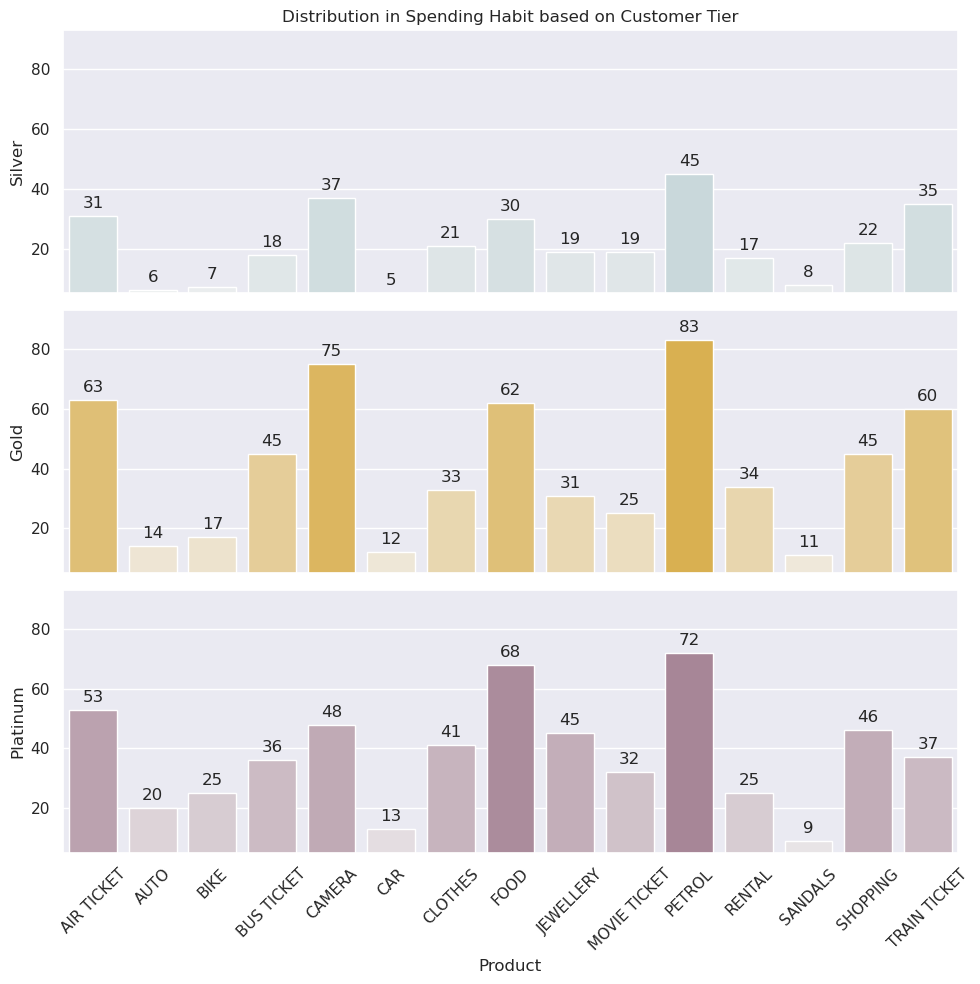

In [18]:
#What are their spending habit in differnt Teir?

# Assuming 'Type' is the column containing the type of spend
data_merged = Cus_N_Spend_df.groupby(['Tier', 'Type']).size().reset_index(name='Count')
order = data_merged['Type'].value_counts().index

# Filter data by a specific product, e.g., 'Platinum'
filtered_data_ax1 = data_merged[data_merged['Tier'] == 'Silver']
filtered_data_ax2 = data_merged[data_merged['Tier'] == 'Gold']
filtered_data_ax3 = data_merged[data_merged['Tier'] == 'Platinum']


max_count = filtered_data_ax2['Count'].max()

# Set up the matplotlib figure
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)


# Create the Seaborn color palette
grad_color_s = sns.light_palette("#A4C7CE", reverse=False, as_cmap=True)
grad_color_g = sns.light_palette("#F0B93A", reverse=False, as_cmap=True)
grad_color_p = sns.light_palette("#A2708A", reverse=False, as_cmap=True)


# Normalize the 'Count' data and map to the color palette
palette_s = [grad_color_s(count/max_count) for count in filtered_data_ax1['Count']]
palette_g = [grad_color_g(count/max_count) for count in filtered_data_ax2['Count']]
palette_p = [grad_color_p(count/max_count) for count in filtered_data_ax3['Count']]


sns.barplot(data=filtered_data_ax1, x='Type', y='Count',palette=palette_s,ax=ax1)
ax1.set_ylabel("Silver")


sns.barplot(data=filtered_data_ax2, x='Type', y='Count',palette=palette_g,ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=filtered_data_ax3, x='Type', y='Count',palette=palette_p,ax=ax3)
ax3.set_ylabel("Platinum")


ax1.set_title('Distribution in Spending Habit based on Customer Tier')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Product')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Set y-axis limits to min and max values
ax1.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax2.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)
ax3.set_ylim(data_merged['Count'].min(), data_merged['Count'].max()+10)


# Annotate values on the bars
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1)
annotate_bars(ax2)
annotate_bars(ax3)

# Finalize the plot
plt.tight_layout(h_pad=1)
plt.show()


In [19]:
Cus_N_Spend_df.head()

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup,Sl No:,Purchase Date,Type,Spend Amt
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,1,2004-01-12,JEWELLERY,485470.80
1,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,2,2004-01-03,PETROL,410556.13
2,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,3,2004-01-15,CLOTHES,23740.46
3,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,4,2004-01-25,FOOD,484342.47
4,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,5,2005-01-17,CAMERA,369694.07


<h2> What product is spend on the most on each of the city? </h2>

In [20]:
# Cus_N_Spend_df

In [21]:
#Tempt Commet out TreeMap

# #data
# amount_sum_by_city_type=Cus_N_Spend_df.groupby(['City','Type'])['Spend Amt'].sum().reset_index()
# tier_counts_by_city = Cus_N_Spend_df.groupby(['City', 'Type']).size().reset_index(name='Tier_Count')

# result_df = pd.merge(amount_sum_by_city_type, tier_counts_by_city, on=['City', 'Type'])

# fig = px.treemap(result_df,path=['City','Type'],values='Spend Amt',custom_data='Tier_Count')


# # Update hover template for formatting
# fig.update_traces(
# #     hovertemplate='<b>%{label}</b><br>Value: $%{Amount[0]:,.2f}'
#     hovertemplate='<b>%{label}</b><br>Amount: $%{value:,.2f}<br>Transaction: %{customdata[0]}'
# )

# # Update layout for better visualization
# fig.update_layout(
#     margin=dict(l=20, r=20, t=30, b=20),
#     title='Sample Treemap',
# )

# # Show the plot
# fig.show()


In [22]:
# Create a new DataFrame that sums up the Amount and Tier_Count for each City
# summed_df = result_df.groupby('City').agg({
#     'Amount': 'sum',
#     'Tier_Count': 'sum'
# }).reset_index()
#summed_df 

In [23]:
#How much is their credit card limited? Avg Med?

# Define is_skewed function
def is_skewed(mean, median):
    if mean > median:
        return 'Right'
    elif mean < median:
        return 'Left'
    else:
        return 'Symmetric'

# Group by 'Tier' and then aggregate
summary_stats = Cus_cy_df.groupby('Tier')['Limit'].agg(['count','median','mean','std', 'sum']).round(2).reset_index() 
summary_stats['skew'] = summary_stats.apply(lambda row: is_skewed(row['mean'], row['median']), axis=1)
#summary_stats['var'] = summary_stats['var'].apply(lambda x:'{:,.0f}'.format(x))

summary_stats

#how does bank deal with values that have more then 2 decimal place?

,Tier,count,median,mean,std,sum,skew
0,Gold,38,500000.0,500000.00,0.00,19000000.0,Symmetric
1,Platinum,32,10002.0,139688.47,197344.55,4470031.0,Right
2,Silver,30,100001.5,166667.67,151619.15,5000030.0,Right


In [24]:
mode_values = Cus_cy_df.groupby('Tier')['Limit'].describe().round(2).reset_index()
mode_values

,Tier,count,mean,std,min,25%,50%,75%,max
0,Gold,38.0,500000.00,0.00,500000.0,500000.0,500000.0,500000.0,500000.0
1,Platinum,32.0,139688.47,197344.55,10000.0,10001.0,10002.0,100003.0,500000.0
2,Silver,30.0,166667.67,151619.15,100000.0,100000.0,100001.5,100003.0,500000.0


In [25]:
#Clean_Repay_df
#Cus_df.nunique()
#Cus_df.info()
#Spend_df

# SandBox Area

In [26]:
# #Using PLT
# # Count the occurrences of each tier
# tier_counts = Cus_df['Tier'].value_counts().sort_values(ascending=True)

# # Extract labels and counts
# labels = tier_counts.index
# counts = tier_counts.values

# # Create a bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(labels, counts, color=['gold', 'silver', 'blue'])

# # Set labels and title
# plt.xlabel('Customer Tier')
# plt.ylabel('Number of Customers')
# plt.title('Distribution of Customer Tiers')

# # Show the plot
# plt.show()

In [27]:
# Price_list = {'Cheeseburger': 8, 'Fries': 5, 'Lasagna': 12, 'Soup': 5, 'Spaghetti': 10}

# print(Price_list['Spaghetti'])
# Price_list.get('Spaghetti')


# #reassign all the key to different meaning.


In [28]:
# nums = [1,35,12,24,31,51,70,100]


# def count (number):
#     number = sorted(number)
#     x = 0
#     while number[x]<20:
#         x+=1
#     return x
    
# count (nums)


